# Customer Churn - Modeling

## Imports

In [429]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from pprint import pprint
import xgboost as xgb

## Read in data 

In [430]:
df = pd.read_csv('data/processed/customer_churn_fe.csv')
#df.head()
#df.info()

## Logistic Regression

First, we will a baseline model - the logistic regression to get a fundamental understanding of our data and how well our a baseline model performs with it.

### Split variables 

In [431]:
# split into x and y variables

# target variable - churn
y = df['Churn']

# x variables
X = df.drop(columns='Churn')

#print("\nTarget variable:")
#print(y.head())

#print("\nX variables:")
#X.head()
#X.info()

In [432]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=23)

scalar = StandardScaler()

X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)

### Fit model

In [433]:
# instantiate the model
log_model = LogisticRegression(class_weight='balanced', random_state=23)
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)


### Confusion Matrix

In [434]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

[[746 294]
 [ 73 296]]


Text(50.722222222222214, 0.5, 'Actual label')

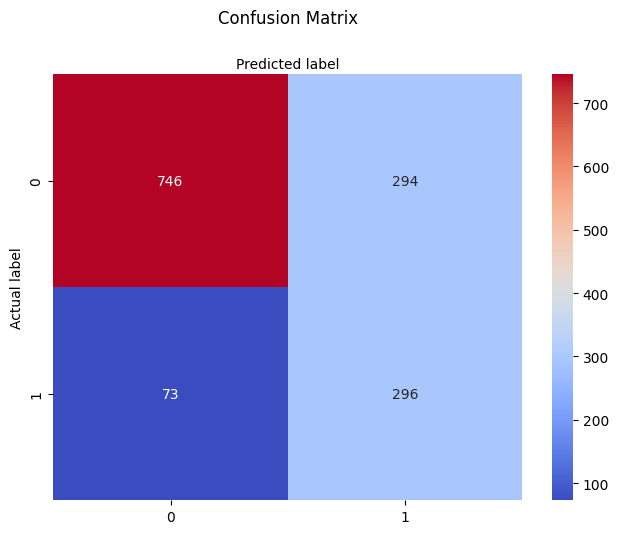

In [435]:
# visualize confusion matrix with a heatmap
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='coolwarm', fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion Matrix", y=1.1)
plt.xlabel("Predicted label")
plt.ylabel("Actual label")

### Classification Report

In [436]:
target_names = ["no churn", "churn"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    no churn       0.91      0.72      0.80      1040
       churn       0.50      0.80      0.62       369

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



### Area Under the Curve

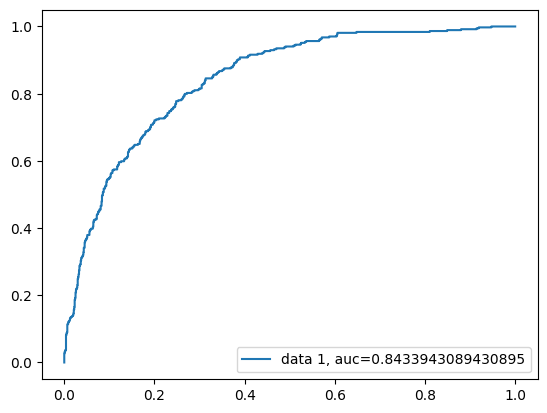

In [437]:
y_pred_prob = log_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Random Forest Classifier

### Fit model

In [438]:
rf = RandomForestClassifier(class_weight='balanced', random_state=23)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

### Confusion Matrix

In [440]:
rf_cnf_matrix = confusion_matrix(y_test,y_pred)
print(rf_cnf_matrix)

[[930 110]
 [186 183]]


### Classification Report

In [428]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1040
           1       0.62      0.50      0.55       369

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



### Hyperparameter Tuning

Key Parameters:
* n_estimators: the amount of trees in our random forest
* max_depth: max number of levels in the trees
* min_samples_split: min number of samples required to split a node (helps prevent overfitting)

In [419]:
param_grid = {
    'n_estimators': [100,200],
    'max_features': ['log2', 'sqrt'],
    'max_depth':[5,10,None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf': [1,5,10],
    'bootstrap':[True, False]
}

rf = RandomForestClassifier()
random_search = RandomizedSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_iter=20, n_jobs=-1, random_state=23)
random_search.fit(X_train, y_train)

print("\nBest parameters found:")
pprint(random_search.best_params_)
print(f"\nBest cross validation score: {random_search.best_score_:.4f}")


Best parameters found:
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 100}

Best cross validation score: 0.8040


### Run Tuned Random Forest Model

In [420]:
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.86      1040
           1       0.63      0.50      0.56       369

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



### New Confusion Matrix

Text(50.722222222222214, 0.5, 'Actual label')

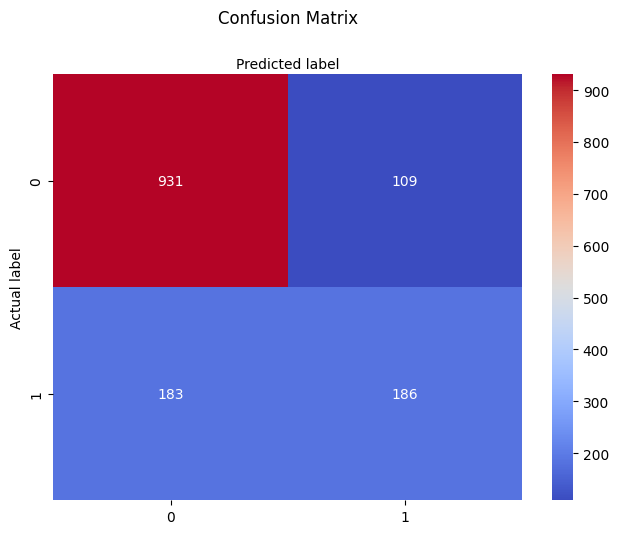

In [421]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# visualize confusion matrix with a heatmap
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# heatmap
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap='coolwarm', fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion Matrix", y=1.1)
plt.xlabel("Predicted label")
plt.ylabel("Actual label")

### New Classification Report

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

### Check for overfitting

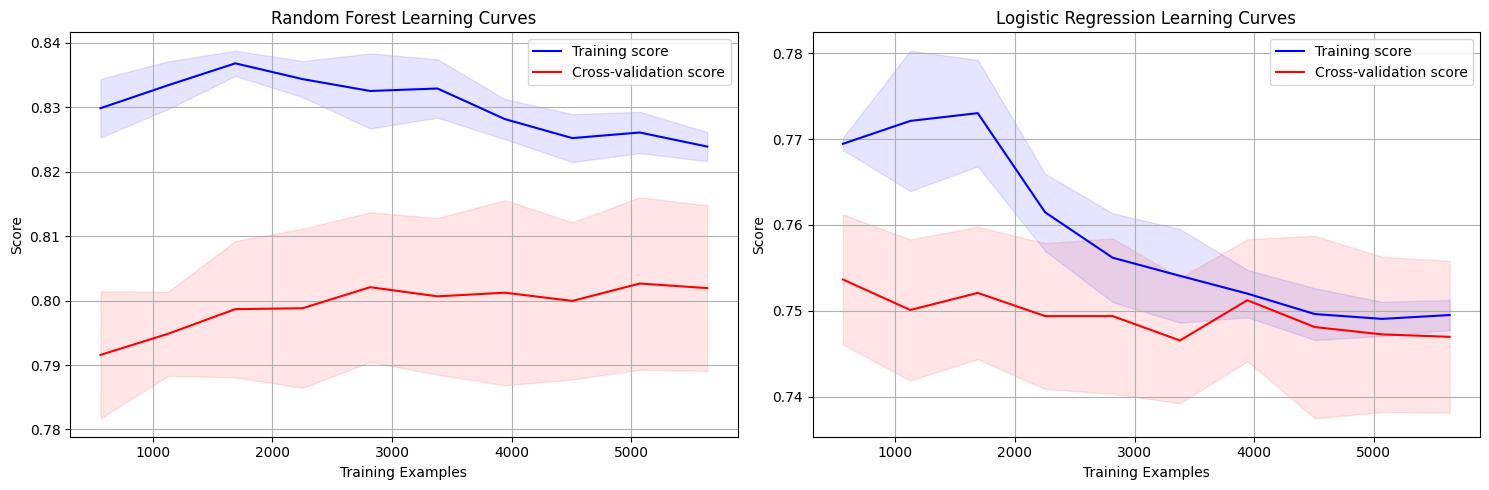

In [422]:
from sklearn.model_selection import learning_curve


def plot_learning_curves(X, y, rf_model, lr_model):
    # Set up the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Create training sizes
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    # Calculate learning curves for Random Forest
    train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
        rf_model, X, y,
        train_sizes=train_sizes,
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )

# Calculate mean and std for Random Forest
    train_mean_rf = np.mean(train_scores_rf, axis=1)
    train_std_rf = np.std(train_scores_rf, axis=1)
    val_mean_rf = np.mean(val_scores_rf, axis=1)
    val_std_rf = np.std(val_scores_rf, axis=1)
    
    # Scale features for Logistic Regression
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Calculate learning curves for Logistic Regression
    train_sizes_lr, train_scores_lr, val_scores_lr = learning_curve(
        lr_model, X_scaled, y,
        train_sizes=train_sizes,
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )
    
    # Calculate mean and std for Logistic Regression
    train_mean_lr = np.mean(train_scores_lr, axis=1)
    train_std_lr = np.std(train_scores_lr, axis=1)
    val_mean_lr = np.mean(val_scores_lr, axis=1)
    val_std_lr = np.std(val_scores_lr, axis=1)
    
    # Plot Random Forest learning curves
    ax1.plot(train_sizes_rf, train_mean_rf, label='Training score', color='blue')
    ax1.plot(train_sizes_rf, val_mean_rf, label='Cross-validation score', color='red')
    ax1.fill_between(train_sizes_rf, train_mean_rf - train_std_rf, train_mean_rf + train_std_rf, alpha=0.1, color='blue')
    ax1.fill_between(train_sizes_rf, val_mean_rf - val_std_rf, val_mean_rf + val_std_rf, alpha=0.1, color='red')
    ax1.set_xlabel('Training Examples')
    ax1.set_ylabel('Score')
    ax1.set_title('Random Forest Learning Curves')
    ax1.legend(loc='best')
    ax1.grid(True)
    
    # Plot Logistic Regression learning curves
    ax2.plot(train_sizes_lr, train_mean_lr, label='Training score', color='blue')
    ax2.plot(train_sizes_lr, val_mean_lr, label='Cross-validation score', color='red')
    ax2.fill_between(train_sizes_lr, train_mean_lr - train_std_lr, train_mean_lr + train_std_lr, alpha=0.1, color='blue')
    ax2.fill_between(train_sizes_lr, val_mean_lr - val_std_lr, val_mean_lr + val_std_lr, alpha=0.1, color='red')
    ax2.set_xlabel('Training Examples')
    ax2.set_ylabel('Score')
    ax2.set_title('Logistic Regression Learning Curves')
    ax2.legend(loc='best')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_learning_curves(X, y, best_rf, log_model)

## XGBoost Binary Classifier

In [423]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [424]:
y_pred = xgb_model.predict(X_test)
print(y_pred)

[0 0 0 ... 0 1 1]


In [425]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test,y_pred))

Accuracy: 76.86%
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1040
           1       0.55      0.63      0.59       369

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.71      1409
weighted avg       0.78      0.77      0.77      1409

